In [7]:
import cv2
import os
import numpy as np
import re  # Regular expression to extract labels from filenames
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [8]:
# Function to load images and corresponding labels
def load_data_from_directory(directory):
    images = []
    labels = []
    # Regular expression to extract the label from filenames
    label_pattern = re.compile(r'(apple|banana|orange|mixed)')  # Adjust based on dataset

    for image_name in os.listdir(directory):
        if image_name.endswith('.jpg'):
            # Extract label from the filename (e.g., apple_1.jpg -> apple)
            label = label_pattern.search(image_name).group(0)
            
            # Load image
            img_path = os.path.join(directory, image_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (128, 128))  # Resize image for CNN input size
            image = img_to_array(image)
            images.append(image)
            
            # Add corresponding label
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Load training and testing data
train_images, train_labels = load_data_from_directory('train')
test_images, test_labels = load_data_from_directory('test')

# Normalize image data to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# One-hot encode labels for CNN
train_labels_cnn = to_categorical(train_labels)
test_labels_cnn = to_categorical(test_labels)

In [9]:
# Extract HOG features from training and test images
from skimage.feature import hog
from skimage import exposure

# Function to extract HOG features from images
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Extract HOG features
        fd, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

# Extract HOG features
train_hog_features = extract_hog_features(train_images)
test_hog_features = extract_hog_features(test_images)

# Train SVM classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(train_hog_features, train_labels)

# Make predictions on test data
svm_predictions = svm_clf.predict(test_hog_features)

# Evaluate the SVM model
print("SVM Classification Report:")
print(classification_report(test_labels, svm_predictions))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.63      0.55        19
           1       0.76      0.72      0.74        18
           2       0.00      0.00      0.00         5
           3       0.50      0.50      0.50        18

    accuracy                           0.57        60
   macro avg       0.44      0.46      0.45        60
weighted avg       0.53      0.57      0.55        60



C:\Users\Dinesh saliyar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dinesh saliyar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dinesh saliyar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
num_classes = len(np.unique(train_labels))
print(f"Number of classes: {num_classes}") 


Number of classes: 4


In [12]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels for CNN 
train_labels_cnn = to_categorical(train_labels, num_classes=4)
test_labels_cnn = to_categorical(test_labels, num_classes=4)

print(f"Train labels shape: {train_labels_cnn.shape}")
print(f"Test labels shape: {test_labels_cnn.shape}")


Train labels shape: (240, 4)
Test labels shape: (60, 4)


In [13]:
# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))  # Number of classes (4)

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Train the CNN model
cnn_model.fit(train_images, train_labels_cnn, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the CNN model
cnn_loss, cnn_acc = cnn_model.evaluate(test_images, test_labels_cnn)
print(f"CNN Model Accuracy: {cnn_acc * 100:.2f}%")


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.4161 - loss: 3.3826 - val_accuracy: 0.0000e+00 - val_loss: 1.1370
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.4099 - loss: 1.4088 - val_accuracy: 0.2917 - val_loss: 1.1414
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.7518 - loss: 0.9409 - val_accuracy: 0.0417 - val_loss: 1.8675
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.8424 - loss: 0.4329 - val_accuracy: 0.3125 - val_loss: 1.5301
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.8696 - loss: 0.3009 - val_accuracy: 0.6250 - val_loss: 0.7969
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.9441 - loss: 0.2101 - val_accuracy: 0.7917 - val_loss: 0.6127
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.9406 - loss: 0.1357 - val_accuracy: 0.1250 - val_loss: 3.2528
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.9425 - loss: 0.1513 - val_accuracy: 0.8958 - val_l

In [15]:
from sklearn.metrics import classification_report

# Predict using the CNN model
cnn_predictions = cnn_model.predict(test_images)
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Generate the classification report for CNN
print("CNN Classification Report:")
print(classification_report(test_labels, cnn_predictions, target_names=label_encoder.classes_))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
CNN Classification Report:
              precision    recall  f1-score   support

       apple       0.85      0.89      0.87        19
      banana       0.76      0.89      0.82        18
       mixed       0.00      0.00      0.00         5
      orange       0.94      0.94      0.94        18

    accuracy                           0.83        60
   macro avg       0.64      0.68      0.66        60
weighted avg       0.78      0.83      0.81        60



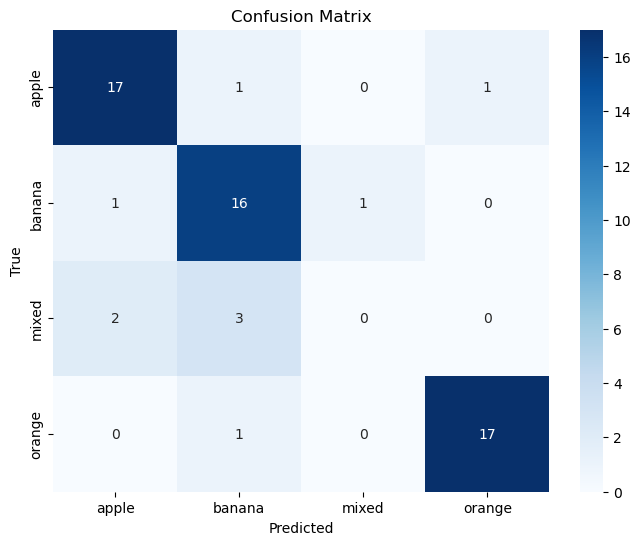

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(test_labels, cnn_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training images
datagen.fit(train_images)

# Train the CNN model using augmented data
cnn_model.fit(datagen.flow(train_images, train_labels_cnn, batch_size=32), epochs=10, validation_data=(test_images, test_labels_cnn))


C:\Users\Dinesh saliyar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.7687 - loss: 0.7539 - val_accuracy: 0.8000 - val_loss: 0.5381
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.7598 - loss: 0.6209 - val_accuracy: 0.8667 - val_loss: 0.5784
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - accuracy: 0.8412 - loss: 0.5322 - val_accuracy: 0.8333 - val_loss: 0.5918
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step - accuracy: 0.8822 - loss: 0.3935 - val_accuracy: 0.8833 - val_loss: 0.4371
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - accuracy: 0.8939 - loss: 0.3278 - val_accuracy: 0.8833 - val_loss: 0.4551
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - accuracy: 0.8695 - loss: 0.3926 - val_accuracy: 0.8833 - val_loss: 0.5056
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.8732 - loss: 0.3779 - val_accuracy: 0.8500 - val_loss: 0.5178
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.8657 - loss: 0.3942 - val_accuracy: 0.8000 - val_loss:

In [18]:
# SVM Performance
print("SVM Performance:")
print(classification_report(test_labels, svm_predictions, target_names=label_encoder.classes_))

# CNN Performance
print(f"CNN Model Accuracy: {cnn_acc * 100:.2f}%")


SVM Performance:
              precision    recall  f1-score   support

       apple       0.48      0.63      0.55        19
      banana       0.76      0.72      0.74        18
       mixed       0.00      0.00      0.00         5
      orange       0.50      0.50      0.50        18

    accuracy                           0.57        60
   macro avg       0.44      0.46      0.45        60
weighted avg       0.53      0.57      0.55        60

CNN Model Accuracy: 83.33%


C:\Users\Dinesh saliyar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dinesh saliyar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dinesh saliyar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
